# Relational Deep Reinforcement Learning

**Plan:**
1. Architecture
2. Agent
3. Environment
4. Training cycle

## Relational architecture

**Input: (b,n,n,1)** = (batch length, linear size, linear size, greyscale)

**Extract entities: (b,n,n,1) -> (b, m, m, 2k)** 
* embedding layer: vocab_size = MAX_PIXELS+1, embedding_dim = n_dim
* convolutional_layer1(kernel_size = (2,2), input_filters = n_dim, output_filters = k, stride = 1, pad = (1,1))
* convolutional_layer2(kernel_size = (2,2), input_filters = k, output_filters = 2k, stride = 1, pad = (1,1))

**Relational block: (b, m, m, 2k) -> (b,d_m)**
* Positional Encoding: (b, m, m, 2k) -> (b, m^2, d_m)
* N Multi-Headed Attention blocks: (b, m^2, d_m) -> (b, m^2, d_m)

**Feature-wise max pooling: (b, m^2, d_m) -> (b, d_m)**

**Multi-Layer Perceptron: (b, d_m) -> (b, d_m)**
* 4 fully connected layers (d_m,d_m) with ReLUs (TODO: add skip-connections)

**Actor output: (b,d_m) -> (b,a)** [a = number of possible actions]
* Single linear layer with softmax at the end

**Critic output: (b,d_m) -> (b,1)** 
* Single linear layer without activation function

## Control architecture

**Input: (b,n,n,1)** = (batch length, linear size, linear size, greyscale)

**Extract entities: (b,n,n,1) -> (b, m, m, 2k)** 
* embedding layer: vocab_size = MAX_PIXELS+1, embedding_dim = n_dim
* convolutional_layer1(kernel_size = (2,2), input_filters = n_dim, output_filters = k, stride = 1, pad = (1,1))
* convolutional_layer2(kernel_size = (2,2), input_filters = k, output_filters = 2k, stride = 1, pad = (1,1))

**1D Convolutional block: (b, m, m, 2k) -> (b, m^2, d_m)**
* Positional Encoding: (b, m, m, 2k) -> (b, m^2, d_m)
* 2 1D convolutional blocks with ReLUs: (b, m^2, d_m) -> (b, m^2, d_m) - pixel-wise

**Feature-wise max pooling: (b, m^2, d_m) -> (b, d_m)**

**Multi-Layer Perceptron: (b, d_m) -> (b, d_m)**
* 4 fully connected layers (d_m,d_m) with ReLUs - feature-wise
* (TODO: add skip-connections)

**Actor output: (b,d_m) -> (b,a)** [a = number of possible actions]
* Single linear layer with softmax at the end

**Critic output: (b,d_m) -> (b,1)** 
* Single linear layer without activation function

In [1]:
import numpy as np
import torch 

import torch.nn as nn
import torch.nn.functional as F

In [2]:
from RelationalModule import RelationalNetworks as rnet
from RelationalModule import ControlNetworks as cnet

In [3]:
from importlib import reload
reload(rnet)
reload(cnet)

<module 'RelationalModule.ControlNetworks' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/RelationalModule/ControlNetworks.py'>

# Embedding layer

In [4]:
import matplotlib.pyplot as plt

In [5]:
vocab_size = 256
n_dim = 3
embed = nn.Embedding(vocab_size, n_dim)

In [6]:
zeros = torch.zeros((10,10), dtype=int)
y_zeros = embed(zeros)
print("y_zeros.shape: ", y_zeros.shape)
print(y_zeros[:,:,0])
print(y_zeros[:,:,1])
print(y_zeros[:,:,2])

y_zeros.shape:  torch.Size([10, 10, 3])
tensor([[0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030,
         0.9030],
        [0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030,
         0.9030],
        [0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030,
         0.9030],
        [0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030,
         0.9030],
        [0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030,
         0.9030],
        [0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030,
         0.9030],
        [0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030,
         0.9030],
        [0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030,
         0.9030],
        [0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030,
         0.9030],
        [0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.9030, 0.90

Same integer values get mapped to same vectors, as it should be. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


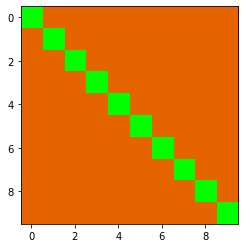

In [7]:
eye = torch.eye(10, dtype=int)
y_eye = embed(eye).detach()
plt.imshow(y_eye.numpy())

Again the embedding works, since each integer value is associated to a particular vector (in this case 3D vector, that can be represented as RGB color once clipped).

# Convolution layers

In [8]:
k_in = 1
k_out = 24
kernel_size = 2
stride = 1
padding = 0

layers = []
layers.append(nn.Conv2d(n_dim*k_in, k_out//2, kernel_size, stride, padding))
layers.append(nn.ReLU())
layers.append(nn.Conv2d(k_out//2, k_out, kernel_size, stride, padding))
#layers.append(nn.ReLU())
net = nn.Sequential(*layers)

In [9]:
def sum_slices(x, axes):
    return x.squeeze().sum(axis=axes).detach()

In [10]:
x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
y = net(x)
print("y.shape: ", y.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([ 176.9918,   76.8794, -221.1962])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
y.shape:  torch.Size([1, 24, 12, 12])


In [11]:
y = y.squeeze().detach()
print(sum_slices(y,(1,2)))
print("y[0,:,:]: ", y[0,:,:])

tensor([-35.3239,  -9.3927,  35.7545, -21.0438,  13.3046,  16.2250,  25.0224,
         34.7849, -32.5136, -44.9192, -31.9720, -20.1204, -45.4257,  18.9467,
        -32.3886,  -9.5785, -18.5796,   7.8179,  34.8244, -29.5308,   0.6400,
         17.0077, -13.3558, -25.9338])
y[0,:,:]:  tensor([[-0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453,
         -0.2453, -0.2453, -0.2453, -0.2453],
        [-0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453,
         -0.2453, -0.2453, -0.2453, -0.2453],
        [-0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453,
         -0.2453, -0.2453, -0.2453, -0.2453],
        [-0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453,
         -0.2453, -0.2453, -0.2453, -0.2453],
        [-0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453,
         -0.2453, -0.2453, -0.2453, -0.2453],
        [-0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453, -0.2453,


So basically each layer is uniform thanks to the input and how convolution works (each slice is the result of the convolution from the same kernel of the same input). All the zeros that can be seen are due to the ReLU activations.

# Positional Encoding

In [12]:
def add_encoding2D(x):
    x_ax = x.shape[-2]
    y_ax = x.shape[-1]

    x_lin = torch.linspace(-1,1,x_ax)
    xx = x_lin.repeat(x.shape[0],y_ax,1).view(-1, 1, y_ax, x_ax).transpose(3,2)

    y_lin = torch.linspace(-1,1,y_ax).view(-1,1)
    yy = y_lin.repeat(x.shape[0],1,x_ax).view(-1, 1, y_ax, x_ax).transpose(3,2)

    x = torch.cat((x,xx,yy), axis=1)
    return x

In [13]:
x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
y = net(x)
print("y.shape: ", y.shape)
y_enc = add_encoding2D(y)
print("y_enc.shape: ", y_enc.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([ 176.9918,   76.8794, -221.1962])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
y.shape:  torch.Size([1, 24, 12, 12])
y_enc.shape:  torch.Size([1, 26, 12, 12])


Let's verify that the last 2 layers have a positional encoding:

y_tmp.shape:  torch.Size([26, 12, 12])


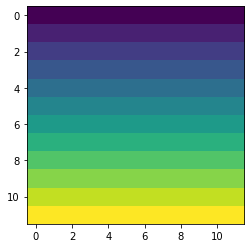

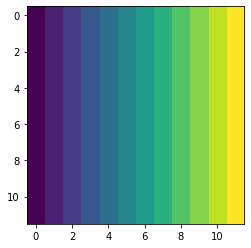

In [14]:
y_tmp = y_enc.squeeze().detach()
print("y_tmp.shape: ", y_tmp.shape)
plt.imshow(y_tmp[-2])
plt.show()
plt.imshow(y_tmp[-1])
plt.show()

A different approach would be to sum these two layers pixel-wise to all other features. Probably it would amplify the importance of the position, at the risk that if the magnitude is too high we would lose data.

Also more complicated encodings are possible; this one is the one I think they used in the paper.

# Projection from 26 to n_features (default 256)

In [15]:
n_features = 256
projection = nn.Linear(k_out + 2, n_features)

In [16]:
x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([ 176.9918,   76.8794, -221.1962])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
x.shape:  torch.Size([1, 24, 12, 12])
x.shape:  torch.Size([1, 26, 12, 12])
x.shape:  torch.Size([1, 26, 144])
x.shape:  torch.Size([1, 144, 26])
x.shape:  torch.Size([1, 144, 256])
x.shape:  torch.Size([144, 1, 256])


Here everything seems clean. Let's see if there is some trace of the positional encoding left. Ideally thanks to the projection now each feature potentially has a positional encoding.

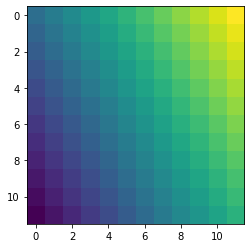

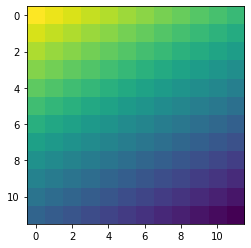

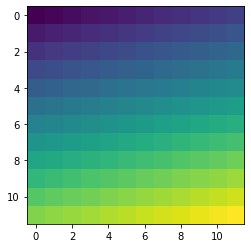

In [17]:
x_tmp = x.squeeze().detach().view(12,12,256)
plt.imshow(x_tmp[:,:,0])
plt.show()
plt.imshow(x_tmp[:,:,128])
plt.show()
plt.imshow(x_tmp[:,:,-2])
plt.show()

Again everything seems fine.

# Relational Block 
Implements the relational block, composed by a Multi-Headed Dot-Product Attention layer followed by a Position-wise Feed-Forward layer. I implement here the former one, whereas I just import the latter from the module, since it's very basic.

In [18]:
hidden_dim = 64
dropout = 0
n_heads = 4

norm = nn.LayerNorm(n_features)
drop = nn.Dropout(dropout) # disabled
attn = nn.MultiheadAttention(n_features, n_heads, dropout)
ff = rnet.PositionwiseFeedForward(n_features, hidden_dim, dropout)

In [19]:
x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)

x_tmp = x # save it for plotting

# From here it has always the same shape
attn_output, attn_output_weights =  attn(x,x,x, key_padding_mask=None) # MHA step
print("attn_output.shape: ", attn_output.shape)
x_add = attn_output + x
print("x_add.shape: ", x_add.shape)
x_norm = drop(norm(x_add))
print("x_norm.shape: ", x_norm.shape)
x_ff = ff(x_norm)
print("x_ff.shape: ", x_ff.shape)
x = drop(norm(x_ff))
print("x.shape: ", x.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([ 176.9918,   76.8794, -221.1962])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
x.shape:  torch.Size([1, 24, 12, 12])
x.shape:  torch.Size([1, 26, 12, 12])
x.shape:  torch.Size([1, 26, 144])
x.shape:  torch.Size([1, 144, 26])
x.shape:  torch.Size([1, 144, 256])
x.shape:  torch.Size([144, 1, 256])
attn_output.shape:  torch.Size([144, 1, 256])
x_add.shape:  torch.Size([144, 1, 256])
x_norm.shape:  torch.Size([144, 1, 256])
x_ff.shape:  torch.Size([144, 1, 256])
x.shape:  torch.Size([144, 1, 256])


We can nonetheless follow the transformation of a single feature along the attention block, to see if something strange happens.

In [20]:
def plot_layer(x, layer=0):
    x = x.squeeze().detach()[:,layer]
    plt.imshow(x.view(12,12))
    plt.show()

Input


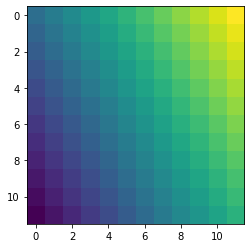

Attention output


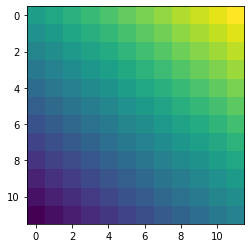

Input + attention


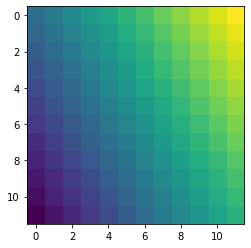

After LayerNorm


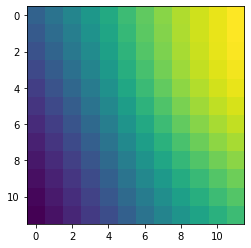

After position-wise FF


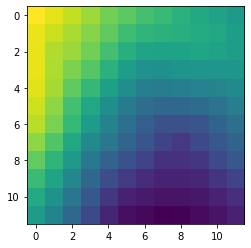

After LayerNorm


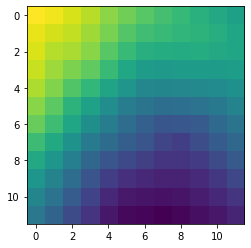

In [21]:
print("Input")
plot_layer(x_tmp)
print("Attention output")
plot_layer(attn_output)
print("Input + attention")
plot_layer(x_add)
print("After LayerNorm")
plot_layer(x_norm)
print("After position-wise FF")
plot_layer(x_ff)
print("After LayerNorm")
plot_layer(x)

Here we didn't see anything suspicious, with the attention layer not doing much and the only real change happening during the positionwise feed forward, in which we make a convolution of the 256 features to obtain new ones, so of course after that we are looking at a different feature plane.

**LayerNorm formula**
$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

In [22]:
# What LayerNorm does

E = x_add[0,0,:].mean()
print("E: ", E)
V = x_add[0,0,:].var()
print("V: ", V)
y = (x_add[0,0,:]-E)/torch.sqrt(V+1e-5)
print("LayerNorm by hand: \n", y)
print("LayerNorm: \n", x_norm[0,0,:])

E:  tensor(-0.0122, grad_fn=<MeanBackward0>)
V:  tensor(0.0493, grad_fn=<VarBackward0>)
LayerNorm by hand: 
 tensor([ 0.0284,  1.2157, -1.1573,  0.0688,  0.7310,  0.6031,  0.6676,  1.3835,
         0.9950,  1.2959, -0.6308,  1.8772, -0.9499, -0.3141,  1.6242,  0.7809,
        -0.1059, -0.3799,  1.3805, -0.6039, -1.3889,  1.2424,  0.4985,  0.7495,
         0.7886,  1.9311, -0.6990,  0.4695,  0.1626, -0.4700,  1.2492, -0.2175,
        -0.4678, -0.1953,  0.4560, -1.4421, -0.6232, -0.0535, -1.5531, -0.4257,
         0.2913, -1.1472, -0.5887,  0.6002,  0.4235,  2.0421,  0.7562, -0.2007,
        -0.1215, -0.2481, -1.3256,  1.0848,  0.3430,  0.1390,  0.3757,  0.0451,
        -0.7191,  0.6880,  0.4480, -1.5937,  0.4631,  2.0827,  2.0120, -1.4430,
         0.1889,  0.7064, -0.6214,  1.0987, -1.6761,  0.5927,  1.3023, -0.6014,
         0.0991,  0.2188,  0.5064, -1.1640,  0.3713, -0.6570, -0.5317,  0.1632,
        -0.5617,  0.2554, -1.7161, -0.1190, -0.7513,  0.7122,  0.1694, -0.5682,
        -1.

# Featurewise MaxPooling

For each feature, take the maximum value among the pixels.

In [101]:
x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)

x_tmp = x # save it for plotting

# From here it has always the same shape
attn_output, attn_output_weights =  attn(x,x,x, key_padding_mask=None) # MHA step
print("attn_output.shape: ", attn_output.shape)
x_add = attn_output + x
print("x_add.shape: ", x_add.shape)
x_norm = drop(norm(x_add))
print("x_norm.shape: ", x_norm.shape)
x_ff = ff(x_norm)
print("x_ff.shape: ", x_ff.shape)
x = drop(norm(x_ff))
print("x.shape: ", x.shape)
# Max pooling feature-wise
x, _ = torch.max(x, axis=0)
print("x.shape: ", x.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([-298.4777,  -25.8635,  142.6594])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
x.shape:  torch.Size([1, 24, 12, 12])
x.shape:  torch.Size([1, 26, 12, 12])
x.shape:  torch.Size([1, 26, 144])
x.shape:  torch.Size([1, 144, 26])
x.shape:  torch.Size([1, 144, 256])
x.shape:  torch.Size([144, 1, 256])
attn_output.shape:  torch.Size([144, 1, 256])
x_add.shape:  torch.Size([144, 1, 256])
x_norm.shape:  torch.Size([144, 1, 256])
x_ff.shape:  torch.Size([144, 1, 256])
x.shape:  torch.Size([144, 1, 256])
x.shape:  torch.Size([1, 256])


Nothing much to control here.

# Alternative to max pooling - Linear projection

In [54]:
reload(rnet)

<module 'RelationalModule.RelationalNetworks' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/RelationalModule/RelationalNetworks.py'>

In [55]:
linear_proj = nn.Linear(144,1) # needs to know how many pixels there are

In [58]:
x = torch.zeros((1,1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)

x_tmp = x # save it for plotting

# From here it has always the same shape
attn_output, attn_output_weights =  attn(x,x,x, key_padding_mask=None) # MHA step
print("attn_output.shape: ", attn_output.shape)
x_add = attn_output + x
print("x_add.shape: ", x_add.shape)
x_norm = drop(norm(x_add))
print("x_norm.shape: ", x_norm.shape)
x_ff = ff(x_norm)
print("x_ff.shape: ", x_ff.shape)
x = drop(norm(x_ff))
print("x.shape: ", x.shape)

# Feature-wise projection
x = x.transpose(-1,0)
print("x.shape (before linear): ", x.shape)
shape = x.shape
x = linear_proj(x).reshape(shape[0],shape[1])
print("x.shape: ", x.shape)
x = x.transpose(-1,0)
print("x.shape: ", x.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([ 176.9918,   76.8794, -221.1962])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
x.shape:  torch.Size([1, 24, 12, 12])
x.shape:  torch.Size([1, 26, 12, 12])
x.shape:  torch.Size([1, 26, 144])
x.shape:  torch.Size([1, 144, 26])
x.shape:  torch.Size([1, 144, 256])
x.shape:  torch.Size([144, 1, 256])
attn_output.shape:  torch.Size([144, 1, 256])
x_add.shape:  torch.Size([144, 1, 256])
x_norm.shape:  torch.Size([144, 1, 256])
x_ff.shape:  torch.Size([144, 1, 256])
x.shape:  torch.Size([144, 1, 256])
x.shape (before linear):  torch.Size([256, 1, 144])
x.shape:  torch.Size([256, 1])
x.shape:  torch.Size([1, 256])


## Residual Layer

Here the original paper uses just a Multi-Layer Perceptron, but I thought it would be nice to have sone skip connections in order to make the architecture more flexible.

In [31]:
reload(rnet)

<module 'RelationalModule.RelationalNetworks' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/RelationalModule/RelationalNetworks.py'>

In [32]:
n_hiddens = 256 
residual_layer = rnet.ResidualLayer(n_features, n_hiddens)

In [33]:
residual_layer(x) - x # residual after ReLU

tensor([[-3.0783e-01, -2.6816e-01, -6.9484e-03, -1.0234e-01, -2.0125e-01,
          3.2590e-01,  3.4537e-01,  1.6676e-01, -1.4022e-01, -2.4998e-01,
         -3.7718e-01,  3.2195e-03, -7.9302e-02, -1.0334e-01, -2.3368e-01,
         -1.1705e-01,  2.3923e-01, -3.0261e-02, -8.2137e-02,  2.8402e-01,
          2.4387e-01, -4.7626e-03, -1.7411e-01,  3.4484e-01, -8.5775e-02,
          1.9343e-02, -4.7676e-02, -1.5612e-02, -1.4513e-01, -1.4677e-02,
          4.6080e-01,  9.8367e-02, -1.8759e-01,  2.2664e-01, -3.4613e-01,
         -1.9067e-02,  1.2845e-01, -3.5835e-01,  4.6214e-01, -2.5578e-01,
          3.3528e-01,  5.1272e-03, -1.3390e-01, -3.3258e-02, -5.0577e-01,
          7.5958e-02,  2.8291e-01, -1.9748e-01, -5.2432e-01, -1.7570e-01,
         -1.8359e-01,  1.0159e-01,  3.4431e-01,  1.1114e-01, -7.7553e-02,
         -1.7894e-01,  7.7040e-02, -5.3591e-01,  2.8884e-01,  4.7581e-02,
         -1.4404e-01, -4.6286e-01, -4.0770e-02,  1.6806e-01, -5.2651e-01,
          2.4428e-01,  1.6605e-01, -4.

# Full architecture

In [45]:
reload(rnet)
reload(cnet)

<module 'RelationalModule.ControlNetworks' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/RelationalModule/ControlNetworks.py'>

In [46]:
box_net = rnet.BoxWorldNet(in_channels=1, n_kernels=24, vocab_size=117, n_dim=3,
                              n_features=256, n_attn_modules=2, n_linears=4)

Sequential(
  (0): ExtractEntities(
    (embed): Embedding(117, 3)
    (net): Sequential(
      (0): Conv2d(3, 12, kernel_size=(2, 2), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(12, 24, kernel_size=(2, 2), stride=(1, 1))
      (3): ReLU()
    )
  )
  (1): RelationalModule(
    (net): Sequential(
      (0): PositionalEncoding(
        (projection): Linear(in_features=26, out_features=256, bias=True)
      )
      (1): AttentionBlock(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (attn): MultiheadAttention(
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): PositionwiseFeedForward(
          (w_1): Linear(in_features=256, out_features=64, bias=True)
          (w_2): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (2): AttentionBlock(
        (norm): LayerNorm((256,), eps=1e-0

In [47]:
box_net_v1 = rnet.BoxWorldNet(in_channels=1, n_kernels=24, vocab_size=117, n_dim=3,
                              n_features=256, n_attn_modules=2, n_linears=4, max_pool=False,
                              linear_size=14)

Sequential(
  (0): ExtractEntities(
    (embed): Embedding(117, 3)
    (net): Sequential(
      (0): Conv2d(3, 12, kernel_size=(2, 2), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(12, 24, kernel_size=(2, 2), stride=(1, 1))
      (3): ReLU()
    )
  )
  (1): RelationalModule(
    (net): Sequential(
      (0): PositionalEncoding(
        (projection): Linear(in_features=26, out_features=256, bias=True)
      )
      (1): AttentionBlock(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (attn): MultiheadAttention(
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): PositionwiseFeedForward(
          (w_1): Linear(in_features=256, out_features=64, bias=True)
          (w_2): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (2): AttentionBlock(
        (norm): LayerNorm((256,), eps=1e-0

In [48]:
control_net = cnet.ControlNet(in_channels=1, n_kernels=24, vocab_size=117, n_dim=3,
                              n_features=256, hidden_dim=64, n_control_modules=2, n_linears=4)

In [49]:
x = torch.randint(high=116, size = (1,14,14))

In [50]:
y = box_net_v1(x)
print("y.shape: ", y.shape)
y

x.shape (before ExtractEntities):  torch.Size([1, 14, 14])
x.shape (ExtractEntities):  torch.Size([1, 24, 12, 12])
x.shape (After encoding):  torch.Size([1, 26, 12, 12])
x.shape (Before transposing and projection):  torch.Size([1, 26, 144])
x.shape (PositionalEncoding):  torch.Size([144, 1, 256])
x.shape (RelationalModule):  torch.Size([144, 1, 256])
x.shape (FeaturewiseProjection):  torch.Size([1, 256])
x.shape (BoxWorldNet):  torch.Size([1, 256])
y.shape:  torch.Size([1, 256])


tensor([[ 1.5390e-01, -7.0952e-01, -6.5533e-01, -2.3280e-01,  1.4070e+00,
          1.1377e+00, -5.1626e-01,  6.7379e-01, -2.1708e+00,  4.7738e-01,
          1.0760e-01, -8.9058e-01, -1.4046e+00, -5.7237e-01,  1.6635e-01,
         -4.1910e-01, -1.1328e+00,  7.0878e-01, -1.7152e+00,  3.3344e-01,
         -1.1291e+00,  4.5320e-01,  8.5595e-01,  3.1230e-01,  7.7161e-01,
          2.0477e-01,  1.1913e+00,  2.3102e-01,  4.7967e-01,  4.4859e-01,
          2.6376e-01, -3.8250e-01,  4.9597e-01,  1.6744e+00, -1.2098e+00,
         -6.6775e-01, -1.4222e+00, -1.2581e+00,  5.1194e-01,  1.6870e+00,
          6.8565e-01, -4.4087e-01, -2.5555e-01, -8.3321e-02,  9.2260e-01,
          1.8577e-01, -3.9201e-01, -6.4735e-01,  1.1492e+00, -6.0591e-01,
         -1.0770e+00, -6.9447e-01,  1.1757e+00, -1.4619e+00, -9.9624e-02,
         -2.2770e-01,  7.9717e-01, -3.2119e-02,  9.6015e-01,  7.1545e-01,
         -1.5834e+00, -1.7014e+00, -8.0918e-01,  2.4594e-02, -1.3880e+00,
          6.1104e-01, -1.6140e-01, -1.

In [120]:
y = control_net(x)
print("y.shape: ", y.shape)
y

y.shape:  torch.Size([1, 256])


tensor([[ 1.4898e+00,  7.7120e-02,  2.4382e-01,  6.4252e-01,  2.1385e-01,
          3.1130e-02,  5.5482e-01,  1.6747e-01,  4.6643e-02,  1.6777e+00,
          2.1526e+00,  1.2783e-01,  7.6233e-01,  1.9088e-01,  1.9711e-01,
          8.4925e-02,  1.6465e-01,  4.0268e-01,  1.4540e-01,  1.5118e-01,
          3.4683e-01,  1.6207e+00,  2.1201e-01,  1.0745e-01,  1.5318e-03,
          1.1062e+00,  1.6899e+00,  1.3424e-01, -6.7152e-02,  6.5382e-02,
          1.1693e-01,  1.4884e-01,  1.0919e-01,  9.0146e-01,  3.5792e-01,
          8.5205e-01,  2.1508e-01,  1.0901e-01,  1.2527e-01,  5.7115e-01,
          1.4628e-01,  1.0879e+00,  1.0445e+00,  1.3953e-01,  3.5668e-01,
          4.2492e-01,  2.5978e-02,  1.3901e-01,  1.1301e+00,  1.4053e-01,
          8.8481e-01,  1.0414e+00,  5.5296e-01,  4.3741e-01,  4.7355e-01,
          3.6987e-01,  2.3077e-01,  4.9104e-01,  2.8129e-01,  8.3265e-02,
          3.0584e-01,  9.3229e-01,  1.5149e-01,  2.7432e-01,  1.1416e-01,
          7.6628e-02,  5.5852e-02,  1.

# Multi-channel embedding layer test

Here I just wanted to see how to embed even images with more than one channel

In [22]:
reload(rnet)

<module 'RelationalModule.RelationalNetworks' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/RelationalModule/RelationalNetworks.py'>

In [30]:
get_entities = rnet.ExtractEntities(k_out = 24, k_in=3, n_dim=3)

In [31]:
embed = nn.Embedding(255,3)

In [35]:
x = torch.randint(high=116, size = (3,14,14))

In [36]:
get_entities(x).shape

torch.Size([1, 24, 12, 12])

In [21]:
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
x.shape

torch.Size([10, 3, 14, 14])

In [10]:
bw_net = rnet.BoxWorldNet()

In [11]:
bw_net(x).shape

torch.Size([1, 256])